## Homework 08: Classification

**Due:** Midnight on March 23 (with a 2-hour grace period)  


### Overview

In this final homework before starting our course project, we will introduce the essential machine learning paradigm of **classification**. We will work with a well-known Kaggle dataset—the Pima Indians Diabetes dataset—to determine whether an individual has diabetes (1) or not (0). This is a binary classification task.

As we’ve discussed in this week’s lessons, the classification workflow is similar to what we’ve done for regression, with a few key differences:
- Instead of `RepeatedKFold` we use `RepeatedStratifiedKFold` (read the docs to understand the difference)
- We use classification metrics (e.g., accuracy, precision, recall, F1-score) instead of regression metrics.
- We can explore misclassified instances through a confusion matrix.

For this assignment, you’ll build two models and measure their performance using accuracy. 
1. A **logistic regression** classifier as a baseline.
2. One of the **ensemble** classifiers of your choice.

Because we’ve already covered much of the workflow in our regression assignments, this homework is intentionally concise and less prescriptive.

### Grading

There are 5 graded problems, each worth 5 points, for a total of 25 points.

In [1]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,GridSearchCV
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.preprocessing   import StandardScaler
from tqdm                    import tqdm

from collections import Counter

# globals

random_state = 42


### Problem One:  Load, Explore, and Preprocess the Kaggle Pima Indians Diabetes Dataset 

In the follow cell(s), 
- Download the dataset from Kaggle
- Perform some simple EDA using `.head()`, `.info()` and `.hist()`
    - When using a classification dataset, **always** look to see whether the target is balanced (approximately equal numbers of classes) or not. 
- Create the feature set `X` and the target set `y` (using `Outcome` as the target)
- Scale `X` using `StandardScalar` (since the classification models often prefer this)
- Split the dataset into 80% training and 20% testing sets
- Verify that the graded answer is correct

In [2]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print("Path to dataset files:", path)

filename = 'diabetes.csv'

# Construct the full path to the CSV file and load it into a DataFrame
csv_path = os.path.join(path, filename)
df = pd.read_csv(csv_path)

Path to dataset files: /Users/snyder/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1


In [3]:
# Display the first few rows
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [4]:
# Display the head
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


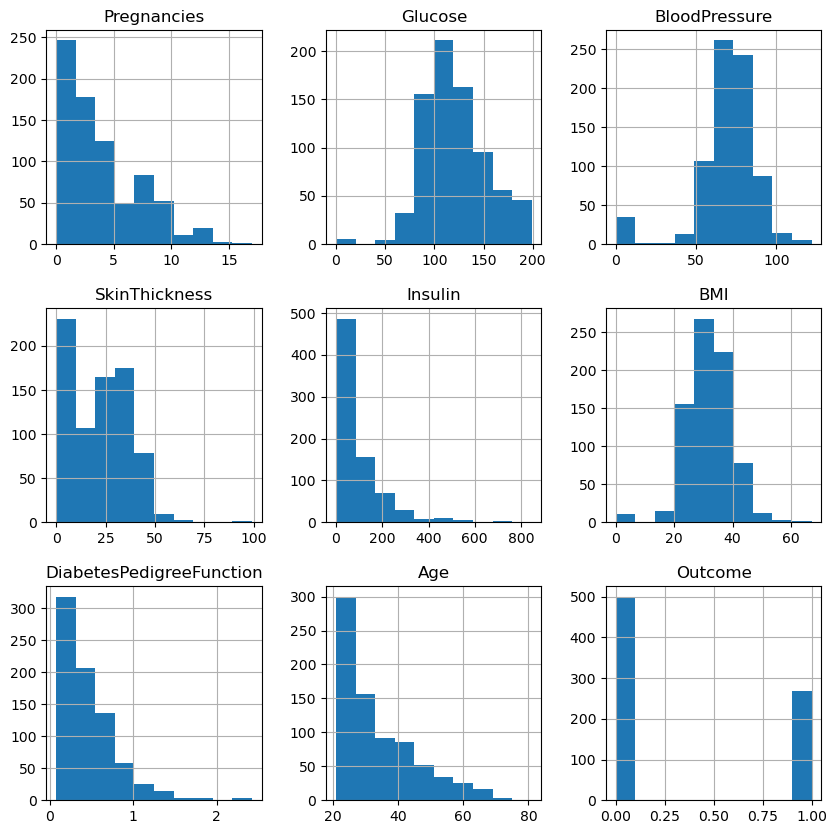

In [5]:
# Simple EDA

df.hist(figsize=(10, 10), layout=(-1,3))
plt.show()

In [6]:
# from sklearn.model_selection import train_test_split

X = df.drop(columns=['Outcome'])            
y = df['Outcome'] 

# Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (614, 8)
y_train shape: (614,)
X_test shape: (154, 8)
y_test shape: (154,)


### Problem 1 Graded Answer

In [7]:
# Nothing to do, but you might want to check and make sure this is correct

a1 = (X_train.shape,X_test.shape)                          

print(f'a1 = {a1}')              # Do not change this line, and DO NOT print anything else in this cell

a1 = ((614, 8), (154, 8))


## Interlude: Wrapper Functions for Running Classification Models

The following cells are adapted from the Week 7 homework in order to use accuracy as the error metric. You can easily modify these
if you wish to consider other metrics. 


In [8]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  # Removes the key safely without error if it exists
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


In [9]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
                   ):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy = mean_cv_accuracy
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # Use only as many parameter values as computed
        partial_param_list = parameter_list[:len(cv_accuracies)]
        
        # Check if our parameter list is Boolean for proper labeling
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Accuracy -----
        ax1.set_title(f"Accuracy vs {param}")
        
        ax1.plot(x_vals,
                 cv_accuracies,
                 marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals,
                 train_accuracies,
                 marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals,
                 test_accuracies,
                 linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]],
                    [max_cv_accuracy],
                    marker='x', label="Best CV Accuracy", color='red')
        
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Accuracy Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


## Problem Two: Classification using Logistic Regression (Baseline)  

For this problem,
- Read the docs for `LogisticRegression`
- Run the model with `class_weight = 'balanced'` and `max_iter=1000`
- Answer the graded questions

In [10]:
# Your code; add as many cells as you need

# Just an example to test

# Define the parameters for LogisticRegression

Params_LR = {
    'class_weight'    : 'balanced',     
    'max_iter'        : 1000,          # Could add other parameters, this is just an example
    'random_state'    : 42,            # Ensures reproducibility
}

mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy =\
           run_model(LogisticRegression, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **Params_LR)

print(f'Mean CV Acc: {mean_cv_accuracy:.4f}')
print(f'Std CV Acc:  {std_cv_accuracy:.4f}')
print(f'Train Acc:   {train_accuracy:.4f}')
print(f'Train Acc:   {test_accuracy:.4f}')

Mean CV Acc: 0.7526
Std CV Acc:  0.0291
Train Acc:   0.7606
Train Acc:   0.6948


### Problem 2.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [11]:
# Insert the mean CV accuracy

a2a = mean_cv_accuracy                        

print(f'a2a = {a2a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = 0.7526


### Problem 2.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [12]:
# Insert the test accuracy

a2b = test_accuracy                        

print(f'a2b = {a2b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = 0.6948


## Problem Three: Classification using Ensemble Methods  

For this problem,
- Choose one of the ensemble methods for classification (see the first code cell above)
- Read about the hyperparameters for the model in the `sklearn` docs
- Tune the model for best performance using the wrapper functions as needed
- Answer the graded questions


### Partial Solution: Just running these three with defaults

In [14]:
# Example usage of run_model with DecisionTreeClassifier
mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
    model=BaggingClassifier,       # pass the class directly
    X_train=X_train,            # use your encoded features
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_repeats=10,
    n_jobs=-1,
    random_state=42                     # optional parameter to control randomness
)

print("Mean CV Accuracy:", mean_cv_accuracy)
print("Std CV Accuracy:", std_cv_accuracy)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Mean CV Accuracy: 0.7452645608423297
Std CV Accuracy: 0.02966898642129684
Train Accuracy: 0.9853420195439739
Test Accuracy: 0.7012987012987013


In [15]:
# Example usage of run_model with RandomForestClassifier
mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
    model=RandomForestClassifier,       # pass the class directly
    X_train=X_train,            # use your encoded features
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_repeats=10,
    n_jobs=-1,
    random_state=42,                    # set for reproducibility
    n_estimators=100                    # number of trees (adjust as needed)
)

print("Mean CV Accuracy:", mean_cv_accuracy)
print("Std CV Accuracy:", std_cv_accuracy)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Mean CV Accuracy: 0.7594468879115022
Std CV Accuracy: 0.03592596488732201
Train Accuracy: 1.0
Test Accuracy: 0.7207792207792207


Sweeping n_estimators: 100%|████████████████████| 10/10 [00:18<00:00,  1.81s/it]


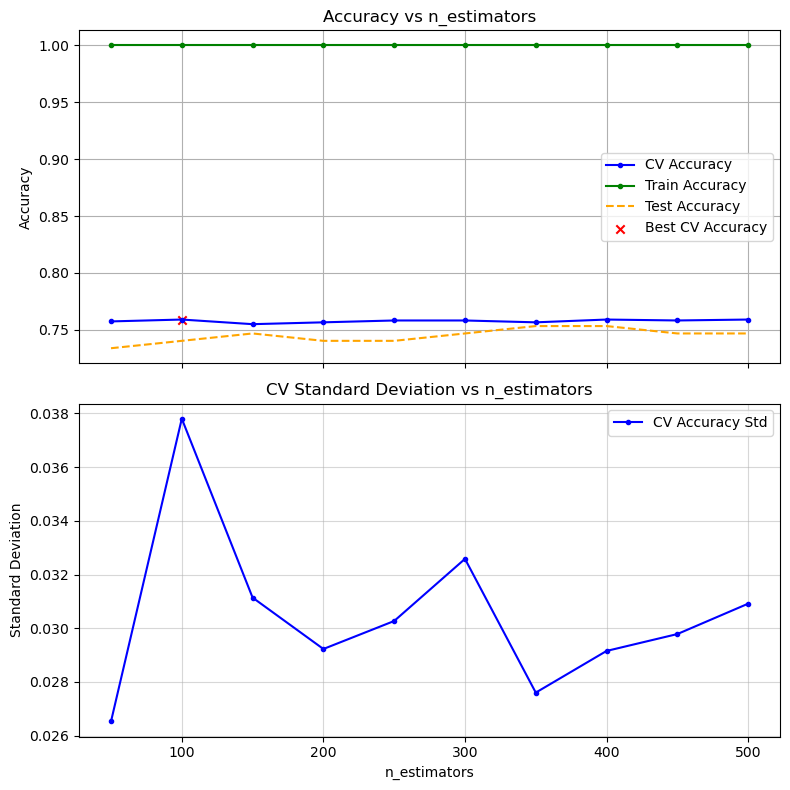

Execution Time: 00:00:18

Parameter n_estimators = 100   Acc = $0.87

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.7589897374383581}



Sweeping max_depth: 100%|█████████████████████████| 8/8 [00:03<00:00,  2.01it/s]


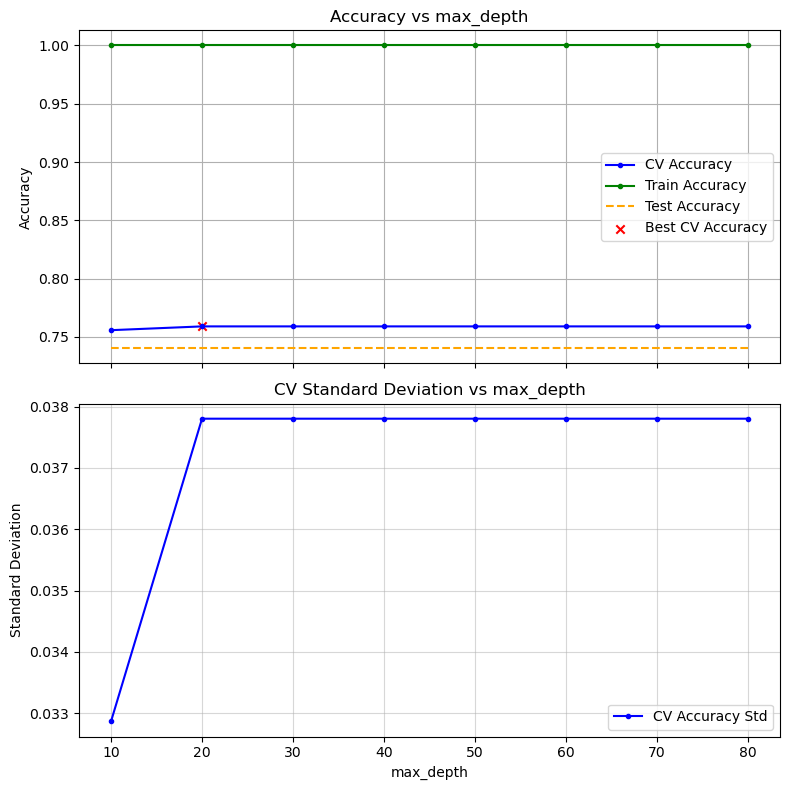

Execution Time: 00:00:04

Parameter max_depth = 20   Acc = $0.87

{'n_estimators': 100, 'max_features': None, 'max_depth': 20, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.7589897374383581}



Sweeping max_features: 100%|██████████████████████| 7/7 [00:03<00:00,  2.01it/s]


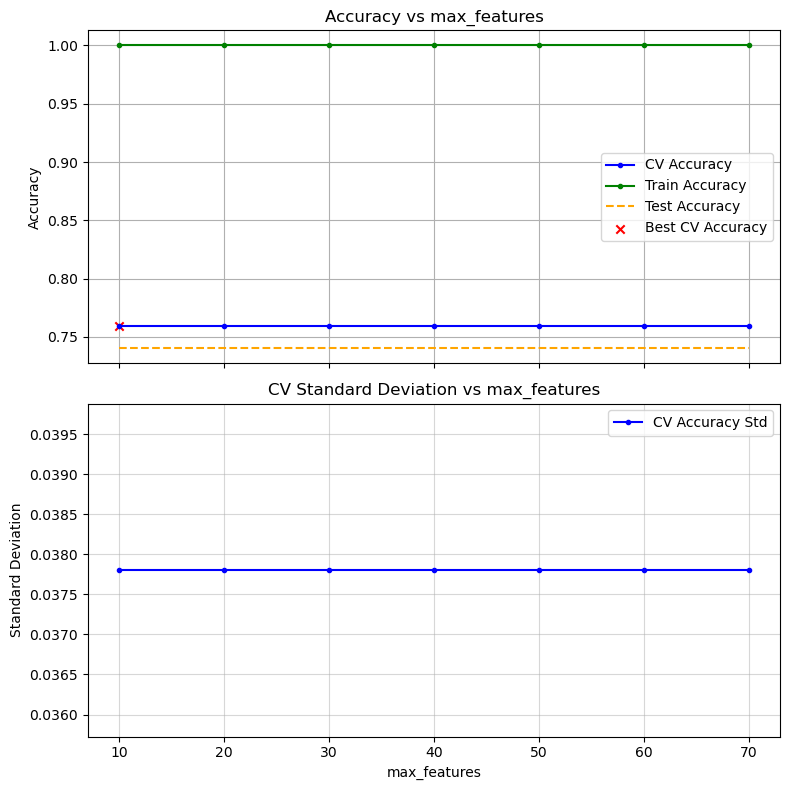

Execution Time: 00:00:03

Parameter max_features = 10   Acc = $0.87

{'n_estimators': 100, 'max_features': 10, 'max_depth': 20, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.7589897374383581}



Sweeping bootstrap: 100%|█████████████████████████| 2/2 [00:01<00:00,  1.93it/s]


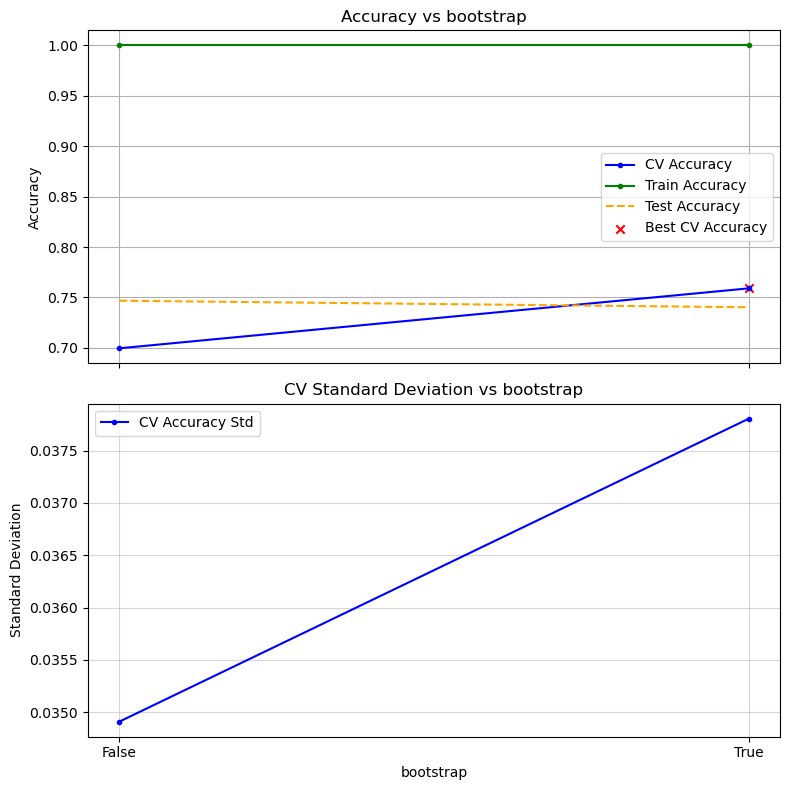

Execution Time: 00:00:01

Parameter bootstrap = True   Acc = $0.87

{'n_estimators': 100, 'max_features': 10, 'max_depth': 20, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.7589897374383581}



,n_estimators,max_features,max_depth,bootstrap,random_state,accuracy_found
0,100,10,20,True,42,0.75899


In [21]:
# Your code here -- Add as many code cells as necessary

# Here is a solution which creates a loop going through all the parameters and ranges

Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    'accuracy_found'   : 0.0 # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                 # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Params_RF = Default_Parameters_Random_Forests.copy() 
Params_RF_List = []

parameters_and_ranges = [('n_estimators', range(50,501,50)),
                         ('max_depth',    range(10,81,10)),
                         ('max_features', range(10,74,10)),
                         ('bootstrap',    [False,True])
                        ]
                         
for (param,parameter_list) in parameters_and_ranges:
    Params_RF = sweep_parameter(RandomForestClassifier,
                                Params_RF,
                                param,
                                parameter_list,
                                n_jobs           = -1,
                                n_repeats        = 2
                               )
    
    print(f"\nParameter {param} = {Params_RF[param]}   Acc = ${Params_RF['accuracy_found']**0.5:,.2f}\n")
    print(Params_RF)
    print()

Params_RF_List.append(Params_RF)

pd.DataFrame(Params_RF_List)

In [16]:
# Example usage of run_model with RandomForestClassifier
mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
    model=GradientBoostingClassifier,       # pass the class directly
    X_train=X_train,            # use your encoded features
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_repeats=10,
    n_jobs=-1,
    random_state=42,                    # set for reproducibility
    n_estimators=100                    # number of trees (adjust as needed)
)

print("Mean CV Accuracy:", mean_cv_accuracy)
print("Std CV Accuracy:", std_cv_accuracy)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Mean CV Accuracy: 0.7652978808476609
Std CV Accuracy: 0.034584219975956274
Train Accuracy: 0.9381107491856677
Test Accuracy: 0.7467532467532467


### Problem 3.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [18]:
# Insert the mean CV accuracy

a3a = 0.0                              # Just to get this cell to run without errors, put your answer here                 

print(f'a3a = {a3a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = 0.0000


### Problem 3.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [19]:
# Insert the test accuracy

a3b = 0.0                              # Just to get this cell to run without errors, put your answer here 

print(f'a3b = {a3b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = 0.0000
